<a href="https://colab.research.google.com/github/almirarana31/datasciencefinal/blob/main/twitter_machine_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [29]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer

file_path = 'twitter_cleaned (1).csv'
twitter_data = pd.read_csv(file_path)

twitter_data['Hashtag Count'] = twitter_data['full_text'].str.count(r"#\w+").fillna(0)

twitter_data['Engagement Ratio'] = (twitter_data['favorite_count'] / twitter_data['total_engagements']).replace(
    [float('inf'), -float('inf')], 0).fillna(0)
twitter_data['Engagement Level'] = pd.cut(
    twitter_data['Engagement Ratio'],
    bins=[-float('inf'), 0.02, 0.05, float('inf')],
    labels=['Low', 'Medium', 'High']
)

vectorizer = CountVectorizer()
hashtags_vectorized = vectorizer.fit_transform(twitter_data['full_text'].fillna(""))

features = pd.DataFrame(hashtags_vectorized.toarray(), columns=vectorizer.get_feature_names_out())
features['Log Followers'] = np.log1p(twitter_data['user_id_str'])  # Using `user_id_str` as an approximation for followers
features['Hashtag Count'] = twitter_data['Hashtag Count']

target = twitter_data['Engagement Level']

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(features, target)

scaler = StandardScaler()
numerical_cols = ['Log Followers', 'Hashtag Count']
X_resampled[numerical_cols] = scaler.fit_transform(X_resampled[numerical_cols])

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)

y_pred = rf_classifier.predict(X_test)
report = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print("Classification Report:\n", report)
print("Confusion Matrix:\n", conf_matrix)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


Classification Report:
               precision    recall  f1-score   support

        High       0.70      0.56      0.62       334
         Low       0.62      0.75      0.68       319

    accuracy                           0.65       653
   macro avg       0.66      0.65      0.65       653
weighted avg       0.66      0.65      0.65       653

Confusion Matrix:
 [[186 148]
 [ 81 238]]


In [30]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from textblob import TextBlob
from datetime import datetime

file_path = 'twitter_cleaned (1).csv'
twitter_data = pd.read_csv(file_path)

def classify_time_period(upload_time):
    hour = upload_time.hour
    if 5 <= hour < 12:
        return "Morning"
    elif 12 <= hour < 17:
        return "Afternoon"
    elif 17 <= hour < 21:
        return "Evening"
    else:
        return "Night"

twitter_data['created_at'] = pd.to_datetime(twitter_data['created_at'], errors='coerce')
twitter_data['Time Period'] = twitter_data['created_at'].apply(lambda x: classify_time_period(x) if pd.notnull(x) else "Unknown")

def get_sentiment(text):
    analysis = TextBlob(text)
    if analysis.sentiment.polarity > 0:
        return "Positive"
    elif analysis.sentiment.polarity < 0:
        return "Negative"
    else:
        return "Neutral"

twitter_data['Sentiment'] = twitter_data['full_text'].fillna("").apply(get_sentiment)

twitter_data['Unique Hashtags'] = twitter_data['full_text'].str.findall(r"#\w+").apply(lambda x: len(set(x)) if x else 0)

twitter_data['Likes-to-Engagements Ratio'] = (twitter_data['favorite_count'] / twitter_data['total_engagements']).replace(
    [float('inf'), -float('inf')], 0).fillna(0)
twitter_data['Engagement Level'] = pd.cut(
    twitter_data['Likes-to-Engagements Ratio'],
    bins=[-float('inf'), 0.02, 0.05, float('inf')],
    labels=['Low', 'Medium', 'High']
)

vectorizer = CountVectorizer()
hashtags_vectorized = vectorizer.fit_transform(twitter_data['full_text'].fillna(""))

features = pd.DataFrame(hashtags_vectorized.toarray(), columns=vectorizer.get_feature_names_out())
features['Log Followers'] = np.log1p(twitter_data['user_id_str'])  # Using user_id_str as proxy for followers
features['Hashtag Count'] = twitter_data['full_text'].str.count(r"#\w+").fillna(0)
features['Unique Hashtags'] = twitter_data['Unique Hashtags']

sentiment_encoded = pd.get_dummies(twitter_data['Sentiment'], prefix='Sentiment')
time_period_encoded = pd.get_dummies(twitter_data['Time Period'], prefix='TimePeriod')
features = pd.concat([features, sentiment_encoded, time_period_encoded], axis=1)

target = twitter_data['Engagement Level']

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(features, target)

label_encoder = LabelEncoder()
y_resampled_encoded = label_encoder.fit_transform(y_resampled)

scaler = StandardScaler()
numerical_cols = ['Log Followers', 'Hashtag Count', 'Unique Hashtags']
X_resampled[numerical_cols] = scaler.fit_transform(X_resampled[numerical_cols])
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled_encoded, test_size=0.2, random_state=42)

<ipython-input-30-276b37a3ef96>:26: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  twitter_data['created_at'] = pd.to_datetime(twitter_data['created_at'], errors='coerce')
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`,

In [31]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix

param_grid = {
    'n_estimators': 200,
    'max_depth': 5,
    'learning_rate': 0.1,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'gamma': 0.1,
    'min_child_weight': 3
}

best_xgb = XGBClassifier(
    random_state=42,
    eval_metric='mlogloss',
    **param_grid
)
best_xgb.fit(X_train, y_train)

y_pred_best_xgb = best_xgb.predict(X_test)
report_best_xgb = classification_report(y_test, y_pred_best_xgb, target_names=label_encoder.classes_)
conf_matrix_best_xgb = confusion_matrix(y_test, y_pred_best_xgb)

print("\nClassification Report (Best XGBoost):\n", report_best_xgb)
print("\nConfusion Matrix (Best XGBoost):\n", conf_matrix_best_xgb)



Classification Report (Best XGBoost):
               precision    recall  f1-score   support

        High       0.67      0.61      0.64       334
         Low       0.63      0.69      0.66       319

    accuracy                           0.65       653
   macro avg       0.65      0.65      0.65       653
weighted avg       0.65      0.65      0.65       653


Confusion Matrix (Best XGBoost):
 [[205 129]
 [ 99 220]]


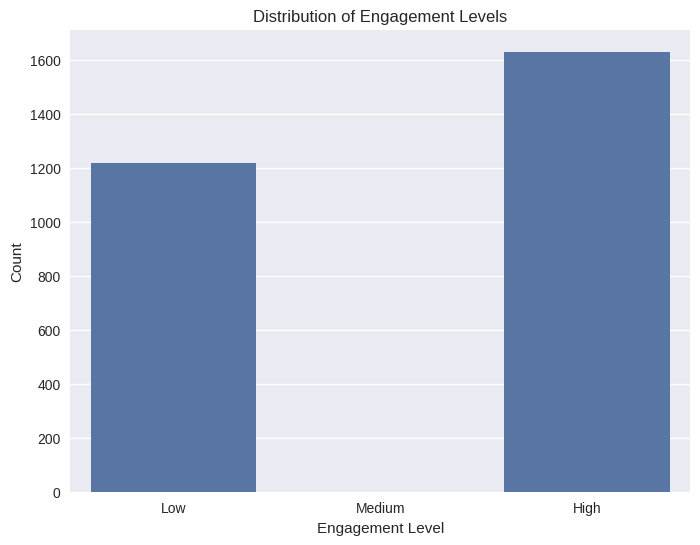

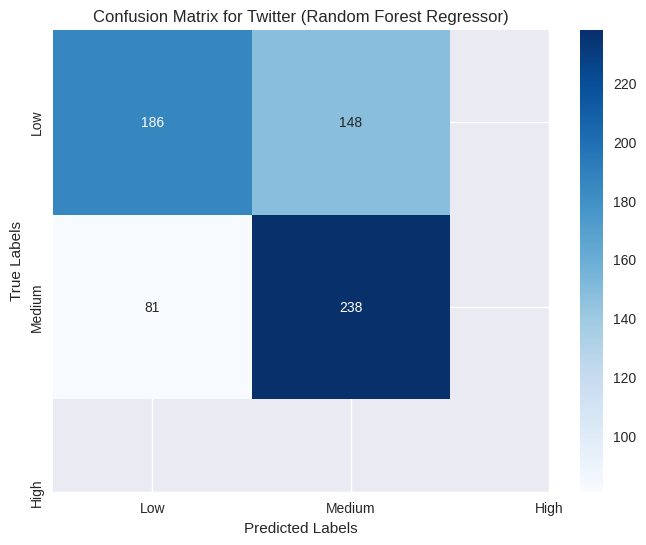

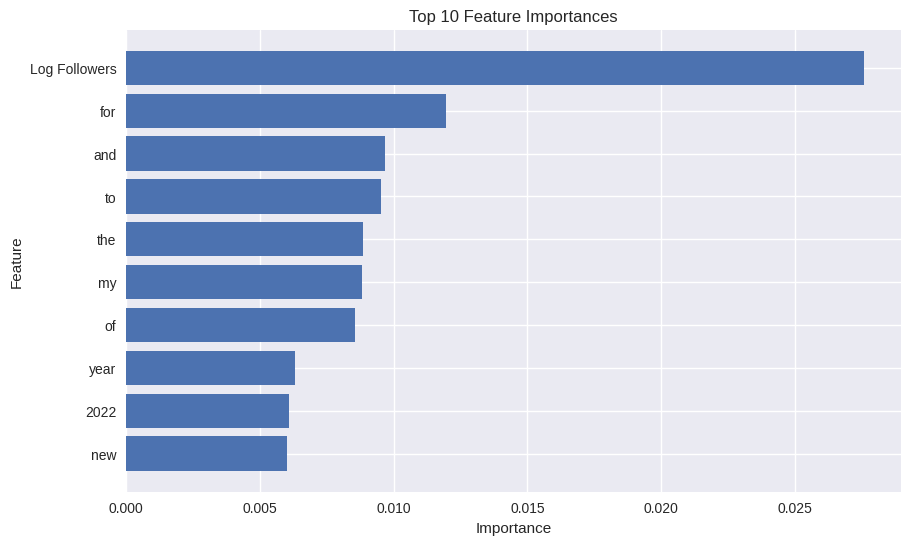

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.inspection import permutation_importance

# 1. Distribution of Engagement Levels
plt.figure(figsize=(8, 6))
sns.countplot(data=twitter_data, x='Engagement Level', order=['Low', 'Medium', 'High'])
plt.title('Distribution of Engagement Levels')
plt.xlabel('Engagement Level')
plt.ylabel('Count')
plt.show()

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Low', 'Medium', 'High'],
            yticklabels=['Low', 'Medium', 'High'])
plt.title('Confusion Matrix for Twitter (Random Forest Regressor)')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

feature_importances = rf_classifier.feature_importances_
feature_names = features.columns

sorted_idx = np.argsort(feature_importances)[-10:]
plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_idx)), feature_importances[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), [feature_names[i] for i in sorted_idx])
plt.title('Top 10 Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()


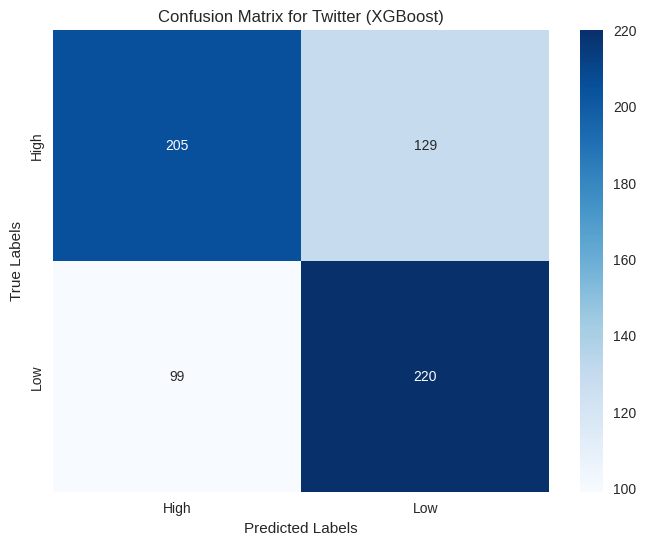

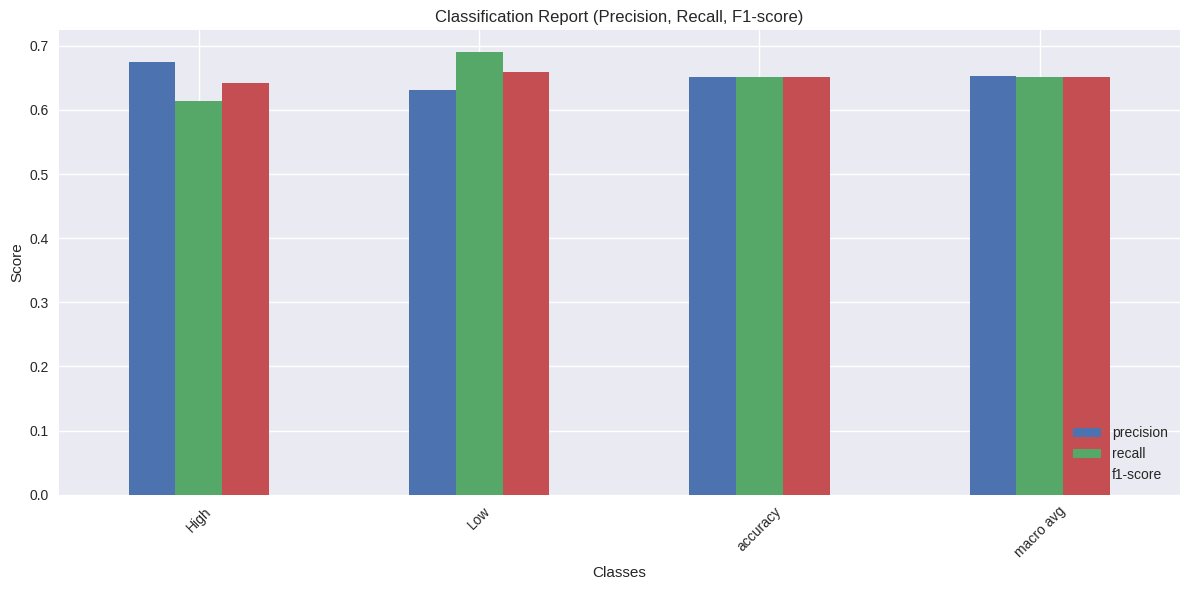

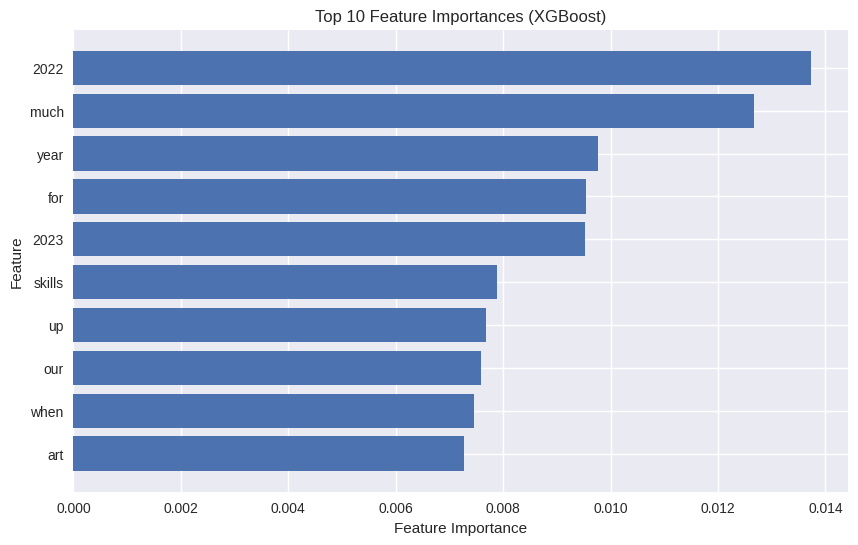

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_best_xgb, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix for Twitter (XGBoost)')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

classification_df = pd.DataFrame(classification_report(y_test, y_pred_best_xgb,
                                                        target_names=label_encoder.classes_, output_dict=True)).T
classification_df = classification_df.iloc[:-1, :3]
classification_df.plot(kind='bar', figsize=(12, 6))
plt.title('Classification Report (Precision, Recall, F1-score)')
plt.xlabel('Classes')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

feature_importances = best_xgb.feature_importances_
sorted_idx = np.argsort(feature_importances)[-10:]
plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_idx)), feature_importances[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), [features.columns[i] for i in sorted_idx])
plt.title('Top 10 Feature Importances (XGBoost)')
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.show()